<a href="https://colab.research.google.com/github/EskelinenElias/ADAML-project1/blob/main/soft_sensor_deveopment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Soft sensor development

LUT University \
BM20A6100 Advanced Data Analysis and Machine Learning - Blended teaching, Lpr 1.9.2025-12.12.2025 \
1st Period - Project work - Intermediary Submission 2 - Data modeling plan

Elias Eskelinen, Vili Niemelä & Matti Aalto \
25.9.2025

---

## Step 0. Initialization

Initialize libraries, set random number state for reproducibility, and the directory where the figures should be saved to.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Set random state
np.random.seed(42)

# Set directory for figures
figs_dir = "figures"

## Step 1. Data onboarding and exploration

Fetch data from kaggle:

In [3]:
import kagglehub

# Fetch the latest version of the dataset from kaggle
data_dir = kagglehub.dataset_download("edumagalhaes/quality-prediction-in-a-mining-process")
data_path = os.path.join(data_dir, os.listdir(data_dir)[0]);

Load data to memory

In [4]:
data = pd.read_csv(data_path)
print(data.shape)

(737453, 24)


Format the data; date column as datetime objects, other columns as decimal numbers.

In [5]:
# Format date column as dates
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S')

# Format other columns as decimal numbers
for c in data.columns[1:]: data[c] = data[c].str.replace(',', '.').astype(float)

The target column is % Silica Concentrate. We plot its value over time

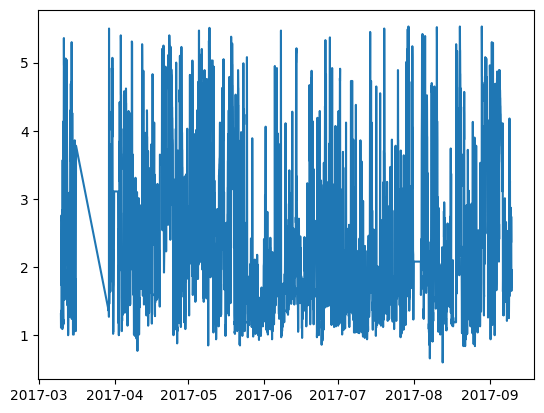

In [6]:
plt.plot(data['date'], data['% Silica Concentrate'])

---

## Step 2. Data pretreatment

Normalizing the data to $z = \frac{x - \mu}{\sigma}$

In [7]:
# Normalize all columns except the date column
numerical_cols = data[data.columns[1:]]

# Calculate means and standard deviations and store them for later use
means = numerical_cols.mean()
stdevs = numerical_cols.std()

# Normalize the data (zero mean, unit variance)
data[data.columns[1:]] = (numerical_cols - means) / stdevs

Synchronizing the data / resampling the data to a frequency of 1 hour

In [8]:
unsynchronized_data = data.copy()

# Resample the data to 1 hour frequency
data = data.groupby("date").mean(numeric_only=True).reset_index()

We drop unusable time windows from the data

In [9]:
# Indices for the usable time windows in the data
usable_indices = [slice(0, 1218), slice(2010, 2946), slice(3474,-1)]

# Extract usable datasets
usable_sets = [data.iloc[i, :] for i in usable_indices]

# Extract usable time windows from the data / drop unusable data
data = pd.concat(usable_sets, ignore_index=True)

---

## Step 3. Data visualization and PCA


In [10]:
# Plotting 

### Fitting the model

Fitting the PCA model

In [11]:
from sklearn.decomposition import PCA

# Dataset without the date column
PCA_data = data[data.columns[1:]]

# Fit the PCA model
pca = PCA().fit(PCA_data)

### Explained variance

Visualizing the the principal components values and cumulative explained

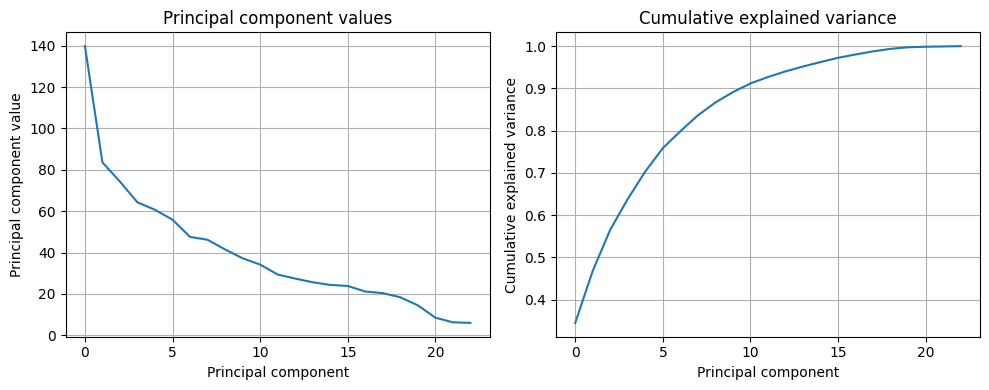

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Principal component values
axs[0].plot(pca.singular_values_)
axs[0].set_title("Principal component values")
axs[0].set_xlabel("Principal component")
axs[0].set_ylabel("Principal component value")
axs[0].grid()

# Cumulative explained variance
axs[1].plot(pca.explained_variance_ratio_.cumsum())
axs[1].set_title("Cumulative explained variance")
axs[1].set_xlabel("Principal component")
axs[1].set_ylabel("Cumulative explained variance")
axs[1].grid()

plt.tight_layout()
plt.savefig(os.path.join(figs_dir, "pca_explained_variance.png"), dpi=300)
plt.show()

### PCA biplots


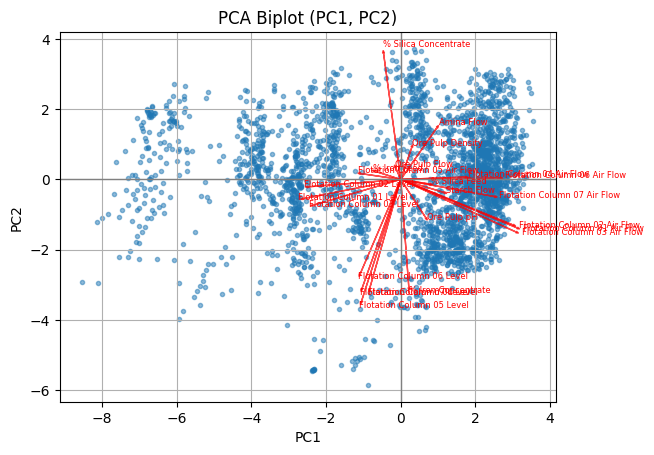

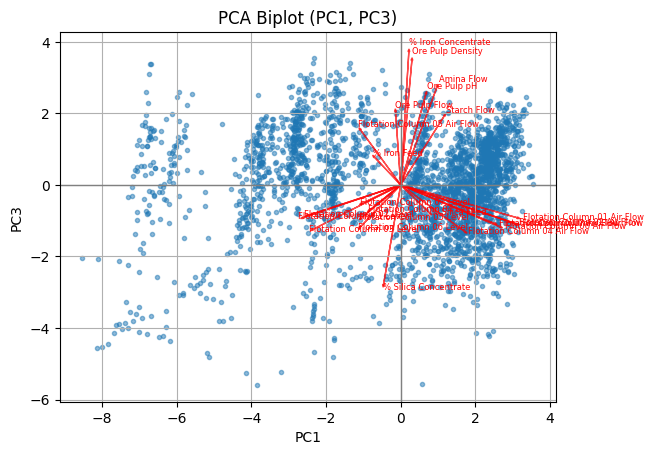

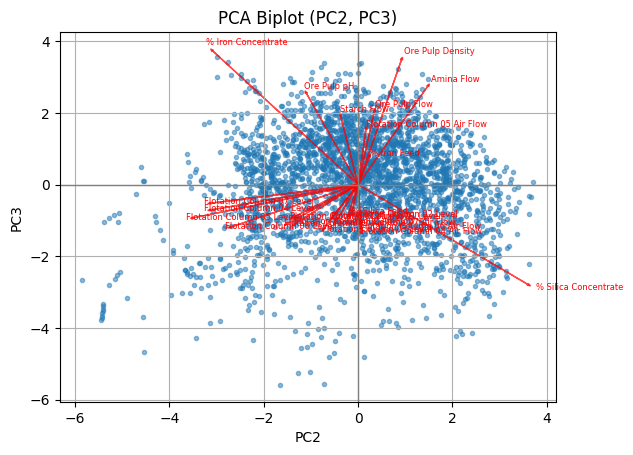

In [13]:
from itertools import combinations

# Get scores and loadings
scores = pca.transform(PCA_data)
loadings = pca.components_.T

# Scale loadings to match the scale of scores for better visualization
scaled_loadings = loadings * np.max(np.abs(scores))

# Choose the number of principal components to plot
num_components = 3

# Plots for each combination of principal components
for (i, j) in combinations(range(min(num_components, loadings.shape[1])), 2):

    text_locations = []

    # Plot datapoints
    plt.scatter(scores[:, i], scores[:, j], marker='.', alpha=0.5, label="Samples")

    # Plot arrows for loadings
    for k, feature in enumerate(PCA_data.columns):
        u, v = scaled_loadings[k, i], scaled_loadings[k, j]
        plt.arrow(0, 0, u, v, color='r', alpha=0.7, head_width=0.05)
        plt.text(1.05*u, 1.05*v, feature, color='r', fontsize=6)

    # Add reference lines
    plt.axhline(0, color='grey', linewidth=1)
    plt.axvline(0, color='grey', linewidth=1)

    # Labels
    plt.xlabel(f"PC{i+1}")
    plt.ylabel(f"PC{j+1}")
    plt.title(f"PCA Biplot (PC{i+1}, PC{j+1})")
    #plt.legend()
    plt.grid()
    plt.savefig(os.path.join(figs_dir, f"PCA_biplot_PC{i+1}_PC{j+1}.png"), dpi=300)
    plt.show()

### Data correlations and distributions

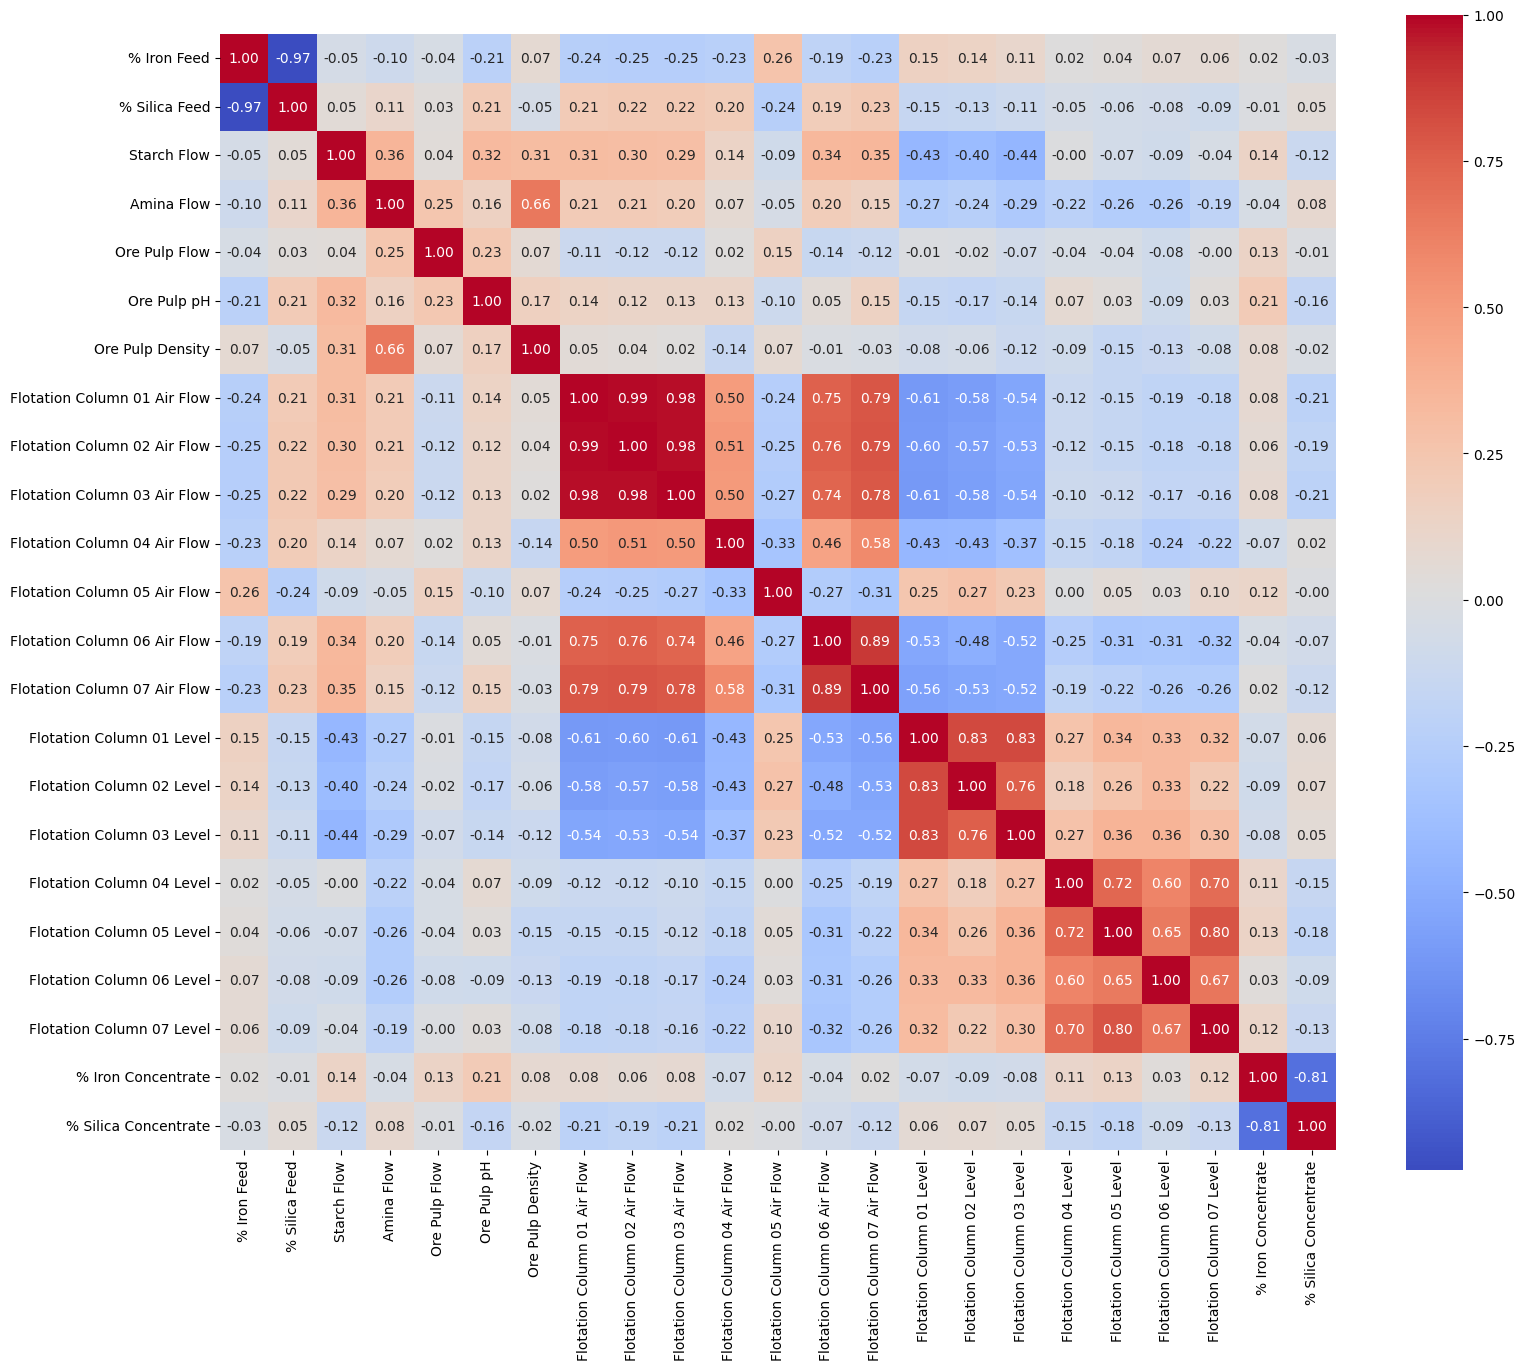

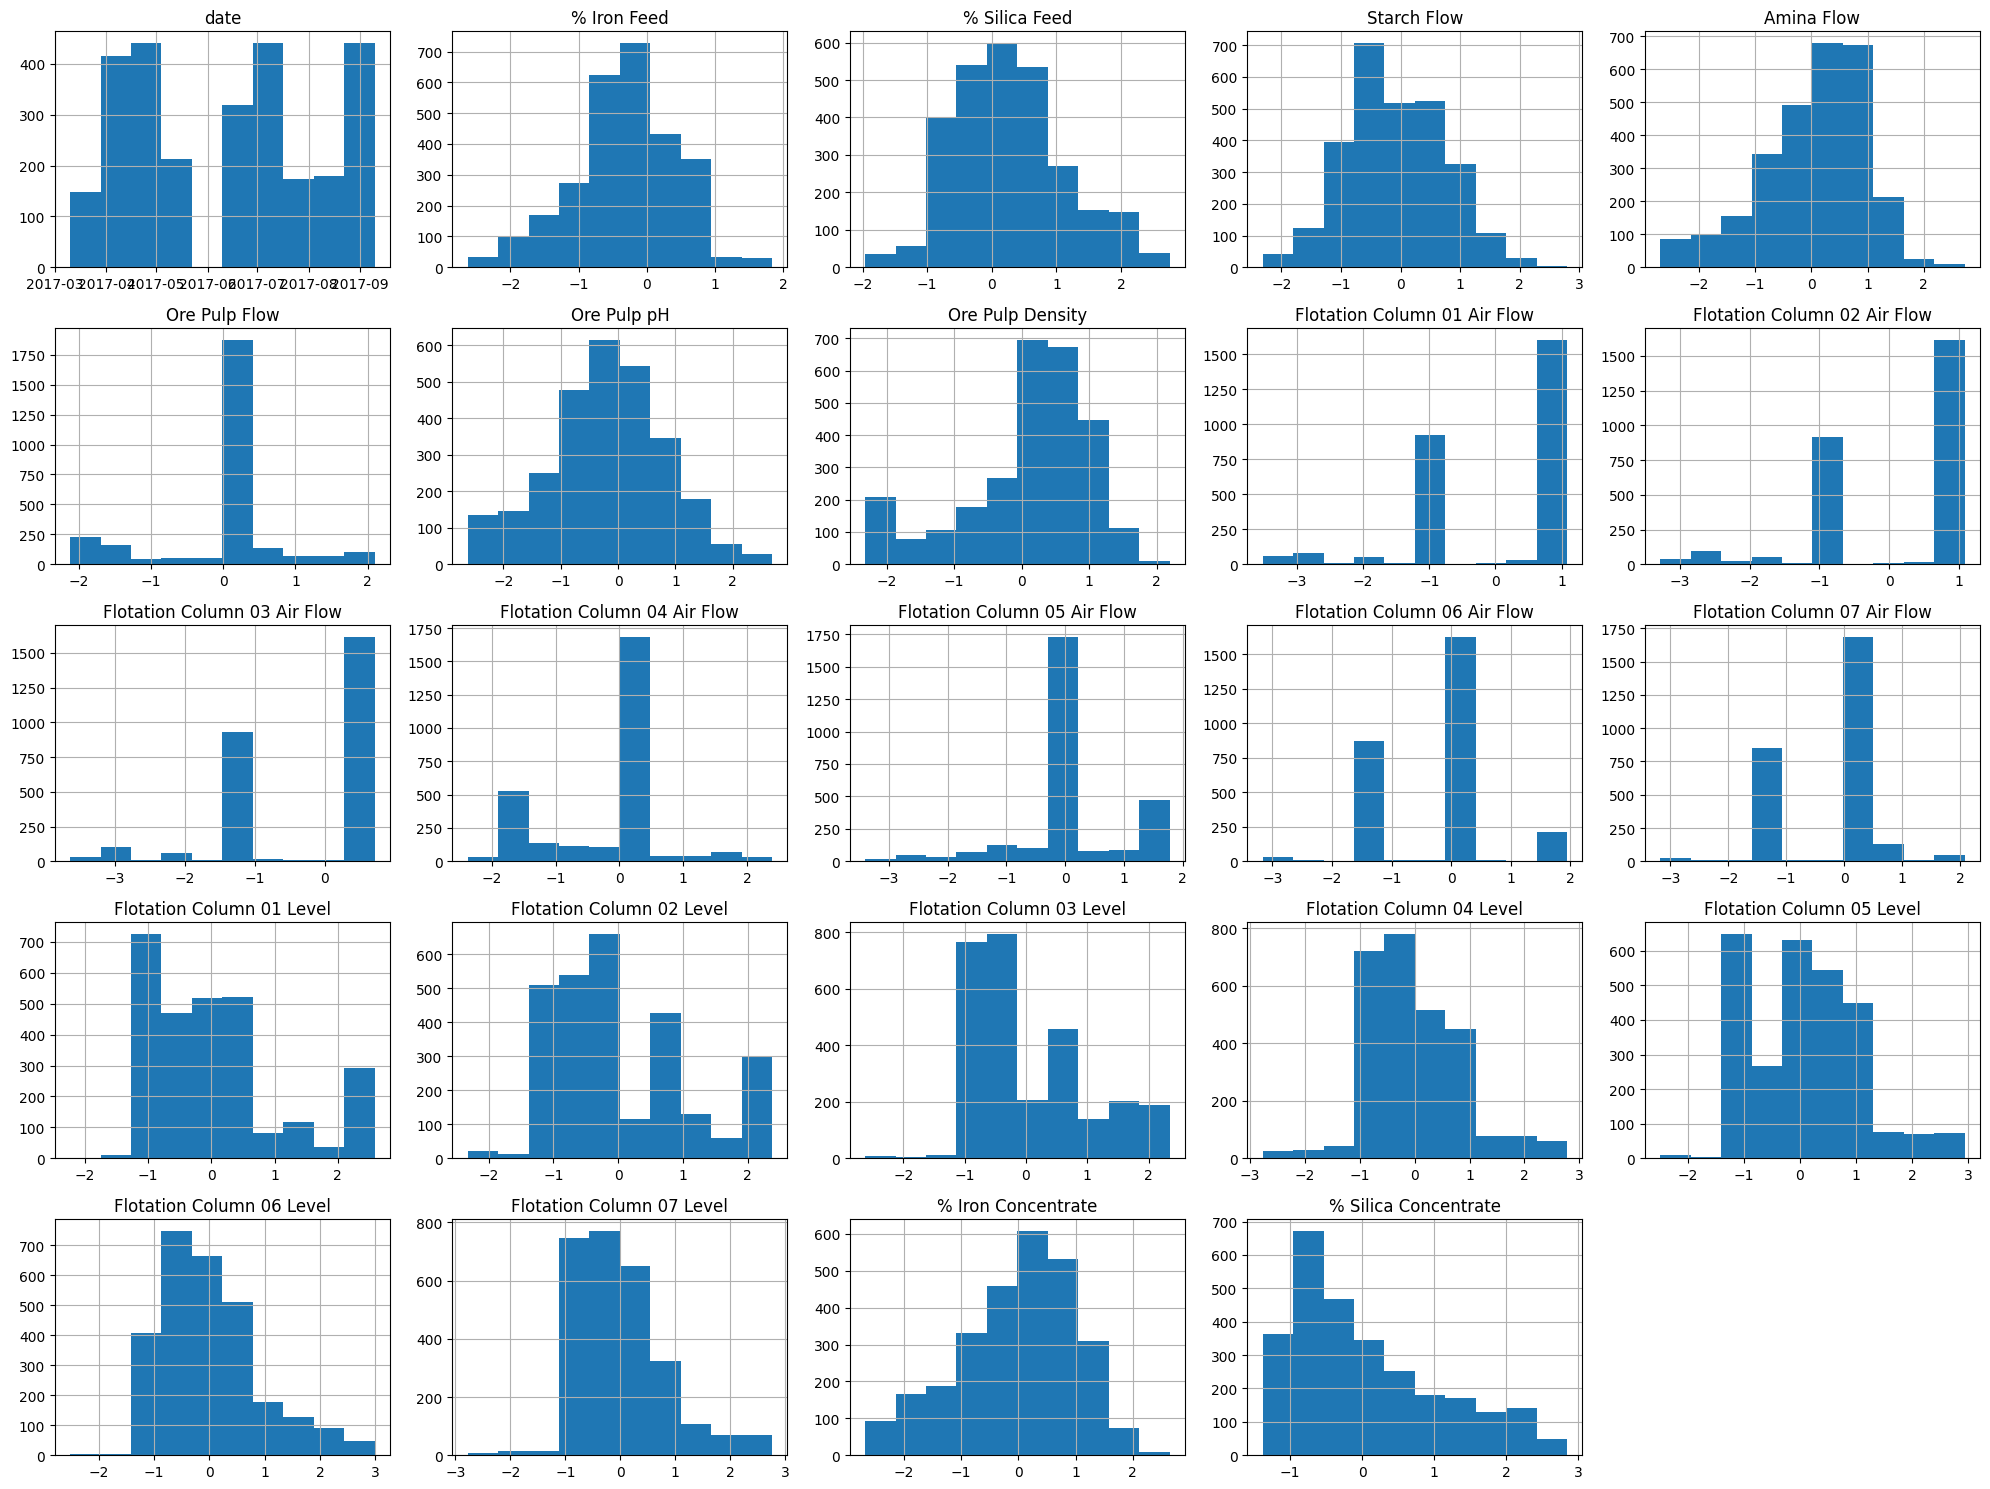

In [14]:
import seaborn as sns

# Correlation matrices
data_corr = data.iloc[:,1:].corr()
plt.figure(figsize=(18, 15))
sns.heatmap(data_corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.savefig(os.path.join(figs_dir, f"correlation_matrix.png"), dpi=300)
plt.show()

# Histograms
data.hist(figsize=(20, 15))
plt.tight_layout()
plt.savefig(os.path.join(figs_dir, f"variable_distributions.png"), dpi=300)
plt.show()

---

## Model training preparations

Our data modeling process begins from splitting the data to training, validation and test sets. Then we train the dynamic model on


We start by defining the predicted variable and the predictor variables:

In [15]:
TARGET_COLUMN = '% Silica Concentrate'
DATE_COLUMN = 'date'
feature_columns = [c for c in data.columns if c not in [DATE_COLUMN, TARGET_COLUMN]]

### Splitting the data to training, validation and test data

We split the data to training set, validation set and test set. The time series data is divided into 3 distinct windows (we dropped the unusable windows in Data Pretreatment), which gives us a natural way to split the data to the 3 sets. The usable time window indices we used to drop the unusable data in Data Pretreatment are stored in the variable ```usable_indices```.

In [16]:
from math import floor

print(unsynchronized_data.shape)

# Split the data to training, validation and test sets
indices = [0, floor(0.6 * len(unsynchronized_data)), floor(0.8 * len(unsynchronized_data)), -1]
data_train, data_val, data_test = [unsynchronized_data.iloc[i:j, :] for i, j in zip(indices[:-1], indices[1:])]

(737453, 24)


### Splitting the lagged training, validation and test sets to sets of $X$ and $y$

Then we split the data to

In [17]:
# Split the training, validation and test sets to sets X and y
X_train, y_train = data_train[feature_columns], data_train[TARGET_COLUMN]
X_val, y_val = data_val[feature_columns], data_val[TARGET_COLUMN]
X_test, y_test = data_test[feature_columns], data_test[TARGET_COLUMN]

### Adding lagged variables

We implement a function `make_lagged` for adding lagged variables as new columns to dataset `X`. If both `X` and `y` are passed, `y` the top rows are cut so that `X` and `y` are the same length. The number of lags can be changed by passing `max_lag`. 

In [18]:
def make_lagged(X: np.ndarray, y: np.ndarray|None=None, max_lag: int=1) -> np.ndarray|tuple[np.ndarray, np.ndarray]:
    X_lagged = pd.concat([X, *[X.shift(i).add_suffix(f"_lag{i}") for i in range(1, max_lag + 1)]], axis=1).dropna(axis=0)
    if y is None: return X_lagged
    return X_lagged, y[max_lag:]

---

## Train models

We train models with different number of lags and lvs. 

### Implement a function to train a dynamic model

We implement a function which takes training data and labels `X_train` and `y_train`, a number of lags `num_lags` and number of latent variables `num_comps` packed in `args`. It then adds lagged variables to the dataset and trains and returns a dynamic `PLSRegression` PLS model. 

In [34]:
from sklearn.cross_decomposition import PLSRegression
import warnings

def train_dynamic_model(args) -> PLSRegression: 
    warnings.filterwarnings('ignore')
    
    # Unpack args
    X_train, y_train, num_lags, num_comps = args

    # Add lagged variables
    X_lagged, y_lagged = make_lagged(X_train, y_train)

    # Train model 
    return PLSRegression(n_components=num_comps).fit(X_lagged, y_lagged) 

We run the function using multiprocessing to speed up model training. The trained models are stored in the array `models`.

In [ ]:
from joblib import Parallel, delayed

# Training parameters
max_lv = 23
max_lags = 10

lag_range = np.arange(0, max_lags+1)
lv_range = np.arange(1, 23)

# Prepare training arguments
training_args = [(X_train, y_train, lag, lv) for lag in lag_range for lv in lv_range]

# Train models using multiprocessing
models = Parallel(n_jobs=-2, prefer="processes")(
    delayed(train_dynamic_model)(args) for args in training_args
)

# Reshape the models array into a matrix with models trained at the same amount of lags as rows
models = np.array(models).reshape(max_lags+1, max_lv-1)

Exception ignored in: <function ResourceTracker.__del__ at 0x104925bc0>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1054cdbc0>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/m

We can then proceed to cross-validation of the models.

## Cross-validate the number of latent variables and the amount of lags

We select the optimal number of lags by training the model with different number of lags and cross-validating the results

In [33]:
from sklearn.cross_decomposition import PLSRegression

press_matrix = np.zeros_like(models)

cv_scores_lags = np.zeros(max_lags + 1) # cross-validation scores for lags
cv_lv_nums = np.zeros(max_lags + 1) # optimal number of lv for different lags
for i, lag in enumerate(lag_range):

    press_vec = np.zeros(max_lv-1) # vector to store PRESS values

    # Make lagged validation set
    X_val_lagged, y_val_lagged = make_lagged(X_val, y_val, lag)

    # Cross validate the model over different number of latent variables
    for j, num_lvs in enumerate(lv_range):

        # Predict the validation set using the model
        y_pred = models[i, j].predict(X_val_lagged)

        # PRESS
        press_score = np.sum( (y_pred - y_val_lagged)**2 )
        press_vec[j] = press_score
        press_matrix[i, j] = press_score


    cv_lv_nums[i] = np.argmin(press_vec) + 1 # optimal lv number
    cv_scores_lags[i] = np.min(press_vec) # cross-validation score

    line, = plt.plot(np.arange(1, max_lv), press_vec, label=f'Lag {lag}')
    plt.plot(np.argmin(press_vec) + 1, np.min(press_vec), "ro", color=line.get_color())
    plt.title("PRESS")
    plt.xlabel("Number of latent variables")
    plt.ylabel("PRESS")

plt.legend()


NameError: name 'lag_range' is not defined

In [ ]:
plt.figure()
plt.plot(np.arange(0, max_num_lags+1), cv_scores_lags)
plt.xlabel("Number of lags (hours)")
plt.ylabel("PRESS")
plt.title("Cross-validation scores for different numbers of lags")

## Testing 

In [ ]:
# Best model indices by PRESS
i, j = np.unravel_index(press_matrix.argmax(), press_matrix.shape)
print(models)

print(len(models), sum([len(m) for m in models])/len(models))

# Get best model 
best_model = models[i][j]

# Test best model 
y_pred = best_model.predict(X_test)
print(y_test.shape, y_pred.shape)


x_test = np.arange(0, len(y_test))
plt.figure()
plt.plot(x_test, y_test, label='target')
plt.plot(x_test, y_pred, label='predicted')
plt.legend()
plt.show()

In [ ]:
mean_error = np.mean(np.abs(y_test - y_pred))

print(mean_error)